#Input data

In [1]:
DATABASE = {
    1:[0.7, -1, 0.1, -1 ],
    2:[0.4, 0.4, 0.5, 0.9],
    3:[-1, 0.6, 0.3, 0.2],
    4:[-1, -1, 0.4, 0.4],
    5:[1, 0.7, -1, -1],
    6:[-1, -1, 0.2, 0.8],
    7:[0.9, 0.9, 0.9, -1]
}
ITEMS = ["A", "B", "C", "D"]
ITEMS_INDEX = {"A": 0, "B": 1, "C": 2, "D": 3}

#Define UPlist and IMCUPList

In [2]:
class UPList:
  def __init__(self, item):
    self.item = {item}
    self.table = {"TID": [], "Prob": []}
    self.expSup = 0
    self.max = 0
  
  def is_maxper_and_avg_per(self, numTransaction, maxper, maxavg):
    ps = []
    if len(self.table["TID"]) != 0:
      ps.append(self.table["TID"][0])
      for i in range(1,len(self.table["TID"])):
        ps.append(self.table["TID"][i]-self.table["TID"][i-1])
    if self.table["TID"][-1] != numTransaction:
      ps.append(numTransaction-self.table["TID"][-1])
    item_avg_per = sum(ps) / len(ps)
    if max(ps) > maxper or item_avg_per > maxavg:
      return False
    return True
  
  def is_periodic(self, numTransaction, maxper, minper, minavg , maxavg):
    ps = []
    if len(self.table["TID"]) != 0:
      ps.append(self.table["TID"][0])
      for i in range(1,len(self.table["TID"])):
        ps.append(self.table["TID"][i]-self.table["TID"][i-1])
      if self.table["TID"][-1] != numTransaction:
        ps.append(numTransaction-self.table["TID"][-1])
      item_avg_per = sum(ps) / len(ps)
      if max(ps) > maxper or min(ps) < minper or item_avg_per > maxavg or item_avg_per < minavg:
        return False
      return True
    return False

  def __eq__(self, other):
    return self.expSup == other.expSup
  def __gt__(self, other):
    return self.expSup > other.expSup
  def __lt__(self, other):
    return self.expSup < other.expSup

class IMCUPList(UPList):
  def __init__(self, U1, U2):
    UPList.__init__(self, "")
    self.item = U1.item.union(U2.item)
    self.index1 = -1
    self.index2 = -1
    self.U1 = U1
    self.U2 = U2
  def genTableIMCUP(self, minSup):
    self.index2 += 1
    for self.index1 in range (self.index1 + 1, len(self.U1.table["TID"])):
      while self.U1.table["TID"][self.index1] > self.U2.table["TID"][self.index2] and self.index2 < len(self.U2.table["TID"]) - 1:
        self.index2 += 1
      if self.U1.table["TID"][self.index1] == self.U2.table["TID"][self.index2]:
        self.table["TID"].append(self.U1.table["TID"][self.index1])
        prob = self.U1.table["Prob"][self.index1] * self.U2.table["Prob"][self.index2]
        self.table["Prob"].append(prob)
        self.expSup += prob
        self.max = max(self.max, prob)
        if minSup - self.expSup > (len(self.U1.table["TID"]) - self.index1 - 1) * self.U1.max:
          return
      if self.index2 == len(self.U2.table["TID"]) - 1:
        self.index1 = len(self.U1.table["TID"]) - 1
        return




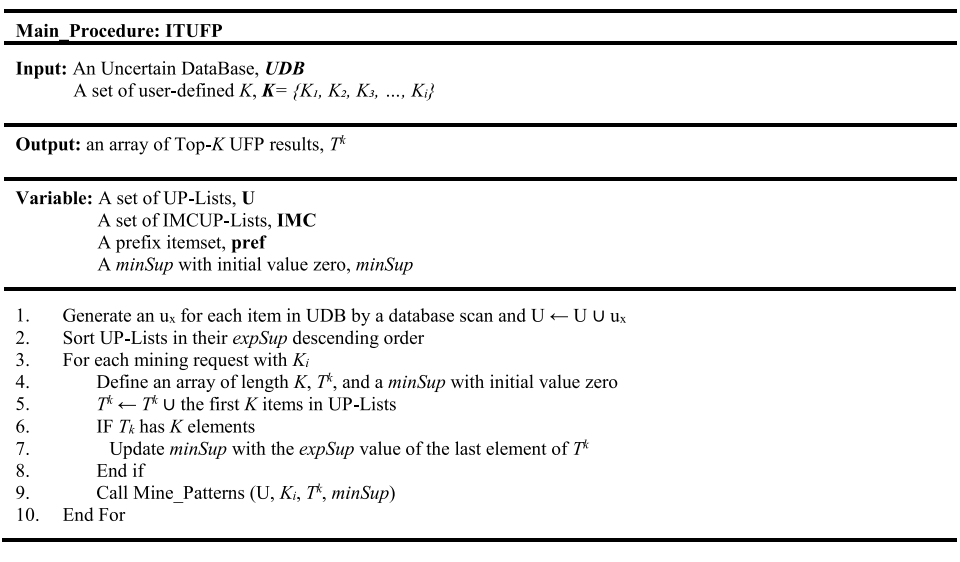

#ITUFP

In [3]:
def ITUFP(UDB, K: list, maxper, maxavg):
  U = []

  IMC =  dict()
  pref =  dict()

  def ITUFP_growth(UIMC,Ki,TK,minSup):
    print(f"*****************************************")
    print(" Mine_patterns")
    for x in range(len(UIMC)):
      print("Considered Ux:", "".join(UIMC[x].item))
      if UIMC[x].expSup > minSup:
        if "".join(UIMC[x].item) not in pref:
          print("".join(UIMC[x].item), "not in pref create IMC and pref for", "".join(UIMC[x].item))
          IMC["".join(UIMC[x].item)] = []
          pref["".join(UIMC[x].item)] = []
        for l in range(x + 1, len(UIMC)):
          if UIMC[l].expSup > minSup:
            print("Considered Ul:", "".join(UIMC[l].item))
            if UIMC[x].expSup * UIMC[l].max > minSup:
              index = -1
              if "".join(UIMC[x].item.union(UIMC[l].item)) in pref["".join(UIMC[x].item)]:
                index = pref["".join(UIMC[x].item)].index("".join(UIMC[x].item.union(UIMC[l].item)))
                if IMC["".join(UIMC[x].item)][index].index1 != len(UIMC[x].table["TID"]) - 1 and IMC["".join(UIMC[x].item)][index].index2 != len(UIMC[l].table["TID"]) - 1:
                  print("Update IMC:",IMC["".join(UIMC[x].item)][index].item)
                  IMC["".join(UIMC[x].item)][index].genTableIMCUP(minSup)
              else:
                C = IMCUPList(UIMC[x], UIMC[l])
                C.genTableIMCUP(minSup)
                IMC["".join(UIMC[x].item)].append(C)
                pref["".join(UIMC[x].item)].append("".join(C.item))
                print("Create IMC:",IMC["".join(UIMC[x].item)][index].item)
              if IMC["".join(UIMC[x].item)][index].expSup > minSup:
                print("IMC:\n",IMC)
                print("pref:\n",pref)
                inserted = False
                for i in range (len(TK["TID"])):
                  if TK["expSup"][i] < IMC["".join(UIMC[x].item)][index].expSup:
                    TK["TID"].insert(i, IMC["".join(UIMC[x].item)][index].item)
                    TK["expSup"].insert(i, IMC["".join(UIMC[x].item)][index].expSup)
                    inserted = True
                    break
                if not inserted:
                  TK["TID"].append(IMC["".join(UIMC[x].item)][index].item)
                  TK["expSup"].append(IMC["".join(UIMC[x].item)][index].expSup)
                if len(TK["TID"]) > Ki:
                  TK["TID"] = TK["TID"][0:Ki]
                  TK["expSup"] = TK["expSup"][0:Ki]
                if len(TK["TID"]) == Ki:
                  minSup = TK["expSup"][-1]
                print("TK:\n",TK)
                print("MinSup:\n",minSup)
        if len(IMC["".join(UIMC[x].item)]) > 1:
          ITUFP_growth(IMC["".join(UIMC[x].item)],Ki,TK,minSup)

  #Create UP-Lists
  ps = dict()
  for item in (ITEMS):
    U.append(UPList(item))
  for T in (UDB.keys()):
    for item in (ITEMS):
      if UDB[T][ITEMS_INDEX[item]] > 0:
        if item not in ps:
          ps[item] = list()
          ps[item].append(T)
        else:
          ps[item].append(T - U[ITEMS_INDEX[item]].table['TID'][-1])

        U[ITEMS_INDEX[item]].expSup += UDB[T][ITEMS_INDEX[item]]
        U[ITEMS_INDEX[item]].max = max(U[ITEMS_INDEX[item]].max, UDB[T][ITEMS_INDEX[item]])
        U[ITEMS_INDEX[item]].table['TID'].append(T)
        U[ITEMS_INDEX[item]].table['Prob'].append(UDB[T][ITEMS_INDEX[item]])
  
  for item in ps.keys():
    temp_final = list(UDB.keys())[-1]-U[ITEMS_INDEX[item]].table['TID'][-1]
    if temp_final > 0:
      ps[item].append(temp_final)
  
  rejected_items = list()
  for i in ps:
    item_avg_per = sum(ps[i]) / len(ps[i])
    if max(ps[i]) > maxper or item_avg_per > maxavg:
      rejected_items.append(i)

  U.sort(reverse=True)
  new_u = list()
  for i in U:
    if "".join(map(str, i.item)) not in rejected_items:
      new_u.append(i)
  
  U = new_u

  TKSet = []
  for Ki in (K):
    print(f"********************{Ki}*********************")
    minSup = 0
    TK = {"TID": [], "expSup": []}
    for i in range (min(Ki,len(U))):
      TK["TID"].append(U[i].item)
      TK["expSup"].append(U[i].expSup)

    #Update minSup if TK has Ki elements
    if len(TK["TID"]) == Ki:
      minSup = TK["expSup"][-1]
    print("TK:\n",TK)
    print("MinSup:\n",minSup)
    ITUFP_growth(U,Ki,TK,minSup)
    TKSet.append(TK)
  return TKSet

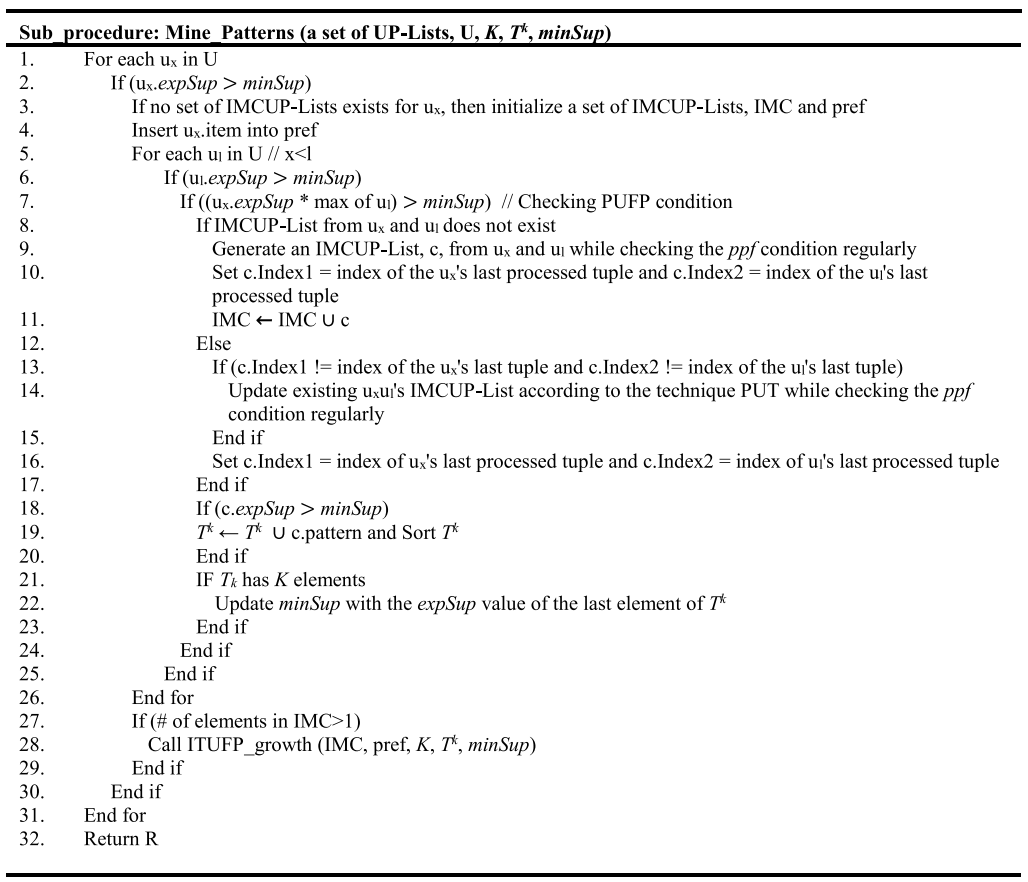

In [4]:
# def ITUFP(UDB, K: list):
#   U = []

#   IMC =  dict()
#   pref =  dict()

#   def ITUFP_growth(UIMC,Ki,TK,minSup):
#     print(f"*****************************************")
#     print(" Mine_patterns")
#     for x in range(len(UIMC)):
#       print("Considered Ux:", "".join(UIMC[x].item))
#       if UIMC[x].expSup > minSup:
#         if "".join(UIMC[x].item) not in pref:
#           print("".join(UIMC[x].item), "not in pref create IMC and pref for", "".join(UIMC[x].item))
#           IMC["".join(UIMC[x].item)] = []
#           pref["".join(UIMC[x].item)] = []
#         for l in range(x + 1, len(UIMC)):
#           if UIMC[l].expSup > minSup:
#             print("Considered Ul:", "".join(UIMC[l].item))
#             if UIMC[x].expSup * UIMC[l].max > minSup:
#               index = -1
#               if "".join(UIMC[x].item.union(UIMC[l].item)) in pref["".join(UIMC[x].item)]:
#                 index = pref["".join(UIMC[x].item)].index("".join(UIMC[x].item.union(UIMC[l].item)))
#                 if IMC["".join(UIMC[x].item)][index].index1 != len(UIMC[x].table["TID"]) - 1 and IMC["".join(UIMC[x].item)][index].index2 != len(UIMC[l].table["TID"]) - 1:
#                   print("Update IMC:",IMC["".join(UIMC[x].item)][index].item)
#                   IMC["".join(UIMC[x].item)][index].genTableIMCUP(minSup)
#               else:
#                 C = IMCUPList(UIMC[x], UIMC[l])
#                 C.genTableIMCUP(minSup)
#                 IMC["".join(UIMC[x].item)].append(C)
#                 pref["".join(UIMC[x].item)].append("".join(C.item))
#                 print("Create IMC:",IMC["".join(UIMC[x].item)][index].item)
#               if IMC["".join(UIMC[x].item)][index].expSup > minSup:
#                 print("IMC:\n",IMC)
#                 print("pref:\n",pref)
#                 inserted = False
#                 for i in range (len(TK["TID"])):
#                   if TK["expSup"][i] < IMC["".join(UIMC[x].item)][index].expSup:
#                     TK["TID"].insert(i, IMC["".join(UIMC[x].item)][index].item)
#                     TK["expSup"].insert(i, IMC["".join(UIMC[x].item)][index].expSup)
#                     inserted = True
#                     break
#                 if not inserted:
#                   TK["TID"].append(IMC["".join(UIMC[x].item)][index].item)
#                   TK["expSup"].append(IMC["".join(UIMC[x].item)][index].expSup)
#                 if len(TK["TID"]) > Ki:
#                   TK["TID"] = TK["TID"][0:Ki]
#                   TK["expSup"] = TK["expSup"][0:Ki]
#                 if len(TK["TID"]) == Ki:
#                   minSup = TK["expSup"][-1]
#                 print("TK:\n",TK)
#                 print("MinSup:\n",minSup)
#         if len(IMC["".join(UIMC[x].item)]) > 1:
#           ITUFP_growth(IMC["".join(UIMC[x].item)],Ki,TK,minSup)

#   #Create UP-Lists
#   for item in (ITEMS):
#     U.append(UPList(item))
#   for T in (UDB.keys()):
#     for item in (ITEMS):
#       if UDB[T][ITEMS_INDEX[item]] > 0:
#         U[ITEMS_INDEX[item]].expSup += UDB[T][ITEMS_INDEX[item]]
#         U[ITEMS_INDEX[item]].max = max(U[ITEMS_INDEX[item]].max, UDB[T][ITEMS_INDEX[item]])
#         U[ITEMS_INDEX[item]].table['TID'].append(T)
#         U[ITEMS_INDEX[item]].table['Prob'].append(UDB[T][ITEMS_INDEX[item]])
#   U.sort(reverse=True)
#   TKSet = []
#   for Ki in (K):
#     print(f"********************{Ki}*********************")
#     minSup = 0
#     TK = {"TID": [], "expSup": []}
#     for i in range (min(Ki,len(U))):
#       TK["TID"].append(U[i].item)
#       TK["expSup"].append(U[i].expSup)

#     #Update minSup if TK has Ki elements
#     if len(TK["TID"]) == Ki:
#       minSup = TK["expSup"][-1]
#     print("TK:\n",TK)
#     print("MinSup:\n",minSup)
#     ITUFP_growth(U,Ki,TK,minSup)
#     TKSet.append(TK)
#   return TKSet

In [5]:
TK = ITUFP(DATABASE, [8,10], 2, 2)
TK



********************8*********************
TK:
 {'TID': [{'B'}, {'C'}, {'D'}], 'expSup': [2.6, 2.4, 2.3]}
MinSup:
 0
*****************************************
 Mine_patterns
Considered Ux: B
B not in pref create IMC and pref for B
Considered Ul: C
Create IMC: {'C', 'B'}
IMC:
 {'B': [<__main__.IMCUPList object at 0x7defc06ccb00>]}
pref:
 {'B': ['CB']}
TK:
 {'TID': [{'B'}, {'C'}, {'D'}, {'C', 'B'}], 'expSup': [2.6, 2.4, 2.3, 1.19]}
MinSup:
 0
Considered Ul: D
Create IMC: {'B', 'D'}
IMC:
 {'B': [<__main__.IMCUPList object at 0x7defc06ccb00>, <__main__.IMCUPList object at 0x7defc06cfc50>]}
pref:
 {'B': ['CB', 'BD']}
TK:
 {'TID': [{'B'}, {'C'}, {'D'}, {'C', 'B'}, {'B', 'D'}], 'expSup': [2.6, 2.4, 2.3, 1.19, 0.48000000000000004]}
MinSup:
 0
*****************************************
 Mine_patterns
Considered Ux: CB
CB not in pref create IMC and pref for CB
Considered Ul: BD
Create IMC: {'C', 'B', 'D'}
IMC:
 {'B': [<__main__.IMCUPList object at 0x7defc06ccb00>, <__main__.IMCUPList object at 0x

[{'TID': [{'B'},
   {'C'},
   {'D'},
   {'B', 'C'},
   {'C', 'D'},
   {'B', 'D'},
   {'B', 'C', 'D'}],
  'expSup': [2.6,
   2.4,
   2.3,
   1.19,
   0.8300000000000001,
   0.48000000000000004,
   0.0936]},
 {'TID': [{'B'},
   {'C'},
   {'D'},
   {'B', 'C'},
   {'C', 'D'},
   {'B', 'D'},
   {'B', 'C', 'D'}],
  'expSup': [2.6,
   2.4,
   2.3,
   1.19,
   0.8300000000000001,
   0.48000000000000004,
   0.0936]}]